Read from a local copy of the ClaimReview Database

### Installation script
```
conda create -n ner python=3.6
source activate ner
conda install -c conda-forge spacy -y
conda install ipython jupyter nb_conda nltk numpy -y
conda install -c conda-forge rake_nltk -y
python -m spacy download en
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_lg
```

In [4]:
import spacy
nlp = spacy.load('en')
doc = nlp(u'Apple is looking at buying U.K. startup for $1 billion')

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Apple 0 5 ORG
U.K. 27 31 GPE
$1 billion 44 54 MONEY


In [5]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load('en_core_web_sm')
doc = nlp(u"Autonomous cars shift insurance liability toward manufacturers")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


In [17]:
fc_path = "fact_checks_20180502.txt"

with open(fc_path) as f:
    fc_raw = f.readlines()

In [18]:
print("No. of Claims:", len(fc_raw))

No. of Claims: 8902


Functions to normalise the text

In [19]:
import re
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

def strip_html(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

def clean_text(data):
    text = re.sub(r'[^\w\s]', ' ', data.lower()).replace("\n", "").replace("  ", " ")
    text = "".join([c for c in text if (c.isalpha() or c == " ")])
    text = text.split(" ")
    output = ""
    for word in text:
        if word not in stopwords.words("english"):
            output = output + " " + word
    return output.strip().replace("  ", " ")

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

def norm_text(data,):
    raw = strip_html(data)
    text = clean_text(raw)
    norm_text = lemmatize_sentence(text)
    return norm_text

In [9]:
from rake_nltk import Rake

# Uses stopwords for english from NLTK, and all puntuation characters by
# default
r = Rake()

# Extraction given the text.
r.extract_keywords_from_text("In August 2018, adhesive replicas of President Donald Trump's recently-destroyed star were placed on the Walk of Fame on Hollywood Boulevard.")

# # Extraction given the list of strings where each string is a sentence.
# r.extract_keywords_from_sentences(<list of sentences>)

# To get keyword phrases ranked highest to lowest.
print(r.get_ranked_phrases())

# To get keyword phrases ranked highest to lowest with scores.
print(r.get_ranked_phrases_with_scores())

['president donald trump', 'hollywood boulevard', 'destroyed star', 'august 2018', 'adhesive replicas', 'walk', 'recently', 'placed', 'fame']
[(9.0, 'president donald trump'), (4.0, 'hollywood boulevard'), (4.0, 'destroyed star'), (4.0, 'august 2018'), (4.0, 'adhesive replicas'), (1.0, 'walk'), (1.0, 'recently'), (1.0, 'placed'), (1.0, 'fame')]


In [7]:
# # ATTEMPTED TO EXTRACT THE VERBS WHICH IS NOT VERY HELPFUL

# import numpy as np
# random_point = np.random.randint(len(fc_raw)-200)
# print(random_point)

# for fc in fc_raw[random_point:random_point+10]:
#     fc = fc.strip("\n")
#     fc = fc.replace("</script>", "").replace('<script type="application/ld+json">', "")
#     fc = json.loads(fc)
#     claim = fc["claimReviewed"]
# #     date_published = fc["datePublished"]
#     review_url = fc["url"]
    
#     print("Claim:", claim)
#     r.extract_keywords_from_text(claim)
#     r.get_ranked_phrases()
#     print(r.get_ranked_phrases_with_scores())
#     doc = nlp(claim)
    
#     # EXTRACTING VERBS WHICH IS NOT VERY HELPFUL
#     print([(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents])
#     verbs = set()
#     for possible_subject in doc:
#         if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
#             verbs.add(possible_subject.head)
#     print(verbs)
#     print()

# DEMO

In [23]:
sentence_array = [
# verbatim 
'Actor Jim Carrey said that the United States is "morally upside down."',
'Liberty University students "were mandated" to attend Sen. Ted Cruz’s presidential \
announcement "or they would be fined.',
'A photograph shows a baseball stadium repurposed as a residential neighborhood.',
'Folding a $5 bill in a specific pattern will reveal a secret image of a stack of pancakes.',
# paraphrase
# Donald Trump mocked "someone with a disability."
'The fact that President Trump mocked someone with a disability shows how idiotic he is.',
'We can see how Paul Ryan is a coward when he blocked all incoming calls and faxes.',
'Being tough on drug is stupid when you know that more people die from prescription \
narcotic painkillers than from heroin and cocaine combined.',
'Barack Obama was arrested for bringing drugs to Japan.'
]
# here I am comparing the text with every claim. 
# If the keyword is spread across sentences they need to be retested again.

In [24]:
text = "".join(sentence_array)
from rake_nltk import Rake
r1 = Rake()
r1.extract_keywords_from_text(text)
r1_scored = r1.get_ranked_phrases_with_scores()
print(r1_scored)

[(16.0, 'president trump mocked someone'), (16.0, 'actor jim carrey said'), (9.0, 'ted cruz ’'), (9.0, 'prescription narcotic painkillers'), (9.0, 'liberty university students'), (9.0, 'baseball stadium repurposed'), (4.0, 'united states'), (4.0, 'specific pattern'), (4.0, 'secret image'), (4.0, 'residential neighborhood'), (4.0, 'presidential announcement'), (4.0, 'photograph shows'), (4.0, 'people die'), (4.0, 'paul ryan'), (4.0, 'morally upside'), (4.0, 'incoming calls'), (4.0, 'disability shows'), (4.0, 'cocaine combined'), (4.0, 'bringing drugs'), (4.0, 'barack obama'), (4.0, 'attend sen'), (4.0, '5 bill'), (1.0, 'would'), (1.0, 'tough'), (1.0, 'stupid'), (1.0, 'stack'), (1.0, 'see'), (1.0, 'reveal'), (1.0, 'pancakes'), (1.0, 'mandated'), (1.0, 'know'), (1.0, 'japan'), (1.0, 'idiotic'), (1.0, 'heroin'), (1.0, 'folding'), (1.0, 'fined'), (1.0, 'faxes'), (1.0, 'fact'), (1.0, 'drug'), (1.0, 'coward'), (1.0, 'blocked'), (1.0, 'arrested')]


In [28]:
import argparse
import sys

from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import six

# from snippets import do_everything

# [START language_entities_text]
def entities_text(text, debug=False):
    """Detects entities in the text."""
    client = language.LanguageServiceClient()

    if isinstance(text, six.binary_type):
        text = text.decode('utf-8')

    # Instantiates a plain text document.
    # [START language_python_migration_entities_text]
    document = types.Document(
        content=text,
        type=enums.Document.Type.PLAIN_TEXT)

    # Detects entities in the document. You can also analyze HTML with:
    #   document.type == enums.Document.Type.HTML
    entities = client.analyze_entities(document).entities

    # entity types from enums.Entity.Type
    entity_type = ('UNKNOWN', 'PERSON', 'LOCATION', 'ORGANIZATION',
                   'EVENT', 'WORK_OF_ART', 'CONSUMER_GOOD', 'OTHER')

    entity_name_list = []
    
    for entity in entities:
        entity_name_list.append([entity.salience, entity.name])
        if debug:
            print('=' * 20)
            print(u'{:<16}: {}'.format('name', entity.name))
            print(u'{:<16}: {}'.format('type', entity_type[entity.type]))
            print(u'{:<16}: {}'.format('metadata', entity.metadata))
            print(u'{:<16}: {}'.format('salience', entity.salience))
            print(u'{:<16}: {}'.format('wikipedia_url',
                  entity.metadata.get('wikipedia_url', '-')))
    
    return entity_name_list
    
    # [END language_python_migration_entities_text]
# [END language_entities_text]

In [35]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
from rake_nltk import Rake

nlp = spacy.load('en_core_web_lg')

def calculate_similarity_score(value_mesh, r1_scored, r2_scored):
    similarity_array = np.maximum.reduce([row for row in value_mesh[0]])
    weighted_similarity = np.multiply(similarity_array, [keyword_tuple[0] for keyword_tuple in r1_scored])
    weighted_similarity_sum = np.sum(weighted_similarity)
    sum_of_weights = np.sum([keyword_tuple[0] for keyword_tuple in r1_scored])
    weighted_similarity_sum_over_weights = weighted_similarity_sum/sum_of_weights
    return weighted_similarity_sum_over_weights

def phrase_vect(text):
    tokens = nlp(text)
    maxpool = np.maximum.reduce([token.vector for token in tokens])
    return maxpool
#     minpool = np.minimum.reduce([token.vector for token in tokens])
#     # https://stackoverflow.com/questions/21816433/
#     result = np.concatenate((minpool,maxpool))
#     return result

def meshgrid(x,y): # DW code !!!
    return (
        [[x_ for x_ in x] for  _ in y],
        [[y_ for  _ in x] for y_ in y])

def cosine(u,v):
#     print(np.shape(u))
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

def calculate_claim_text(claim, text):
#     r1 = Rake()
#     r1.extract_keywords_from_text(claim)
    r1_scored = entities_text(claim)
    print(r1_scored)

#     r2 = Rake()
#     r2.extract_keywords_from_text(text)
    r2_scored = entities_text(text)
#     print(r2_scored)
    
    # assign vectors
    r1_scored_vec = [[claim_keyword_tuple[0], 
                      claim_keyword_tuple[1], 
                      phrase_vect(claim_keyword_tuple[1])] for claim_keyword_tuple in r1_scored]
#     print(len(r1_scored_vec))
#     print(len(r1_scored_vec[0]))

    r2_scored_vec = [[text_keyword_tuple[0], 
                      text_keyword_tuple[1], 
                      phrase_vect(text_keyword_tuple[1])] for text_keyword_tuple in r2_scored]
#     print(len(r1_scored_vec))
#     print(len(r1_scored_vec[0]))
    
    
    # compare statements

    pair_mesh = meshgrid(r1_scored_vec, r2_scored_vec)
    value_mesh = meshgrid([0]*len(r1_scored_vec), [0]*len(r2_scored_vec))

    import numpy as np
    for i,_ in enumerate(pair_mesh[0]):
        for j,_ in enumerate(pair_mesh[0][0]): 
            vector1 = pair_mesh[0][i][j][2]
            vector2 = pair_mesh[1][i][j][2]

            value_mesh[0][i][j] = cosine(vector1, vector2)
            
    return calculate_similarity_score(value_mesh, r1_scored, r2_scored)

100
Actor Jim Carrey said that the United States is "morally upside down."
[[0.8594458699226379, 'Jim Carrey'], [0.14055411517620087, 'United States']]
1.0
Liberty University students "were mandated" to attend Sen. Ted Cruz’s presidential announcement "or they would be fined."
[[0.31338566541671753, 'students'], [0.2413502037525177, 'Liberty University'], [0.2376517951488495, 'Ted Cruz'], [0.20761233568191528, 'announcement']]
1.0000000251902037
A photograph shows a baseball stadium repurposed as a residential neighborhood.
[[0.662848174571991, 'photograph'], [0.1903839409351349, 'neighborhood'], [0.14676788449287415, 'baseball stadium']]
0.8770321452205678
Folding a $5 bill in a specific pattern will reveal a secret image of a stack of pancakes.
[[0.3625143766403198, 'bill'], [0.2544792592525482, 'pattern'], [0.18271289765834808, 'stack'], [0.1302211880683899, 'pancakes'], [0.07007227838039398, 'image']]
0.8998749295642803
Says Donald Trump mocked "someone with a disability."
[[0.4537

/anaconda3/envs/ner/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in float_scalars
/anaconda3/envs/ner/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in reduce


nan
The KKK started a petition to "purge' black people in the United States.
[[0.47193554043769836, 'KKK'], [0.26763617992401123, 'petition'], [0.1771698296070099, 'people'], [0.08325845748186111, 'United States']]
0.532534478801546
An Article accurately compares the salaries of top executives of several large charitable organizations.
[[0.5235207676887512, 'Article'], [0.18924783170223236, 'salaries'], [0.16214004158973694, 'executives'], [0.12509135901927948, 'organizations']]
0.4371499428274004
Tuberculosis recently passed "HIV/AIDS as the leading infectious killer globally."
[[0.5840197205543518, 'Tuberculosis'], [0.31706756353378296, 'HIV/AIDS'], [0.09891270101070404, 'killer']]
0.4211388898998859
"I never once asked that (Megyn Kelly) be removed" as a debate moderator.
[[0.5107548236846924, 'debate moderator'], [0.4892451763153076, 'Megyn Kelly']]
0.4869445772294938
Mike Pence said Michelle Obama 'is the most vulgar First Lady we've ever had'
[[0.6951242685317993, 'Michelle Obama

[[0.6935411095619202, 'circumstance'], [0.30645889043807983, 'Freddie Mac']]
0.5155600727083502
Actor Morgan Freeman said that jailing former presidential candidate Hillary Clinton is the best way to restore public faith in the United States government.
[[0.5417736768722534, 'Morgan Freeman'], [0.2518090307712555, 'Hillary Clinton'], [0.10907873511314392, 'way'], [0.046745166182518005, 'government'], [0.027935735881328583, 'United States'], [0.02265763469040394, 'faith']]
0.6853232675669917
President Donald Trump ordered that the name of Florida's "Obama Highway" be changed back to the "Old Dixie Highway."
[[0.658194899559021, 'Donald Trump'], [0.14842095971107483, 'name'], [0.08160284906625748, 'Obama Highway'], [0.07126707583665848, 'Florida'], [0.04051422327756882, 'Old Dixie Highway']]
0.6619790831706505
Twenty-one people were killed in a mass shooting in Ontario (or other locations).
[[0.37977665662765503, 'people'], [0.27170228958129883, 'shooting'], [0.19395913183689117, 'locati

0.3565017793527897
Says Hillary Clinton "wanted the wall."
[[0.7207030653953552, 'Hillary Clinton'], [0.2792969346046448, 'wall']]
0.6730030582077084
Hillary Clinton will soon be indicted on racketeering charges.
[[0.8012891411781311, 'Hillary Clinton'], [0.1987108737230301, 'racketeering charges']]
0.7305727586574369
Taxpayers footed the bill for prayer rugs at a St. Cloud school district after a lawsuit was brought by CAIR.
[[0.406282514333725, 'Taxpayers'], [0.17659315466880798, 'bill'], [0.12271217256784439, 'prayer rugs'], [0.11448684334754944, 'school district'], [0.07530438899993896, 'St. Cloud'], [0.06746693700551987, 'lawsuit'], [0.037154003977775574, 'CAIR']]
0.5667715432958594
White House staff disabled routine recording of a January 2017 phone call between Vladimir Putin and Donald Trump.
[[0.4158056676387787, 'staff'], [0.2718200981616974, 'White House'], [0.12849479913711548, 'recording'], [0.11996239423751831, 'phone call'], [0.039178382605314255, 'Donald Trump'], [0.024

[[0.5958050489425659, 'creator'], [0.1519506424665451, 'Breaking Bad'], [0.12687037885189056, 'season'], [0.1253739446401596, 'series']]
0.3342764367982496
Says Barack Obama "acknowledged over 20 times" that his administration’s Deferred Action for Parents of Americans "immigration edict was a violation of law and the separation of powers."
[[0.49173757433891296, 'Barack Obama'], [0.14684276282787323, 'immigration edict'], [0.07570517808198929, 'times'], [0.05259992182254791, 'Action'], [0.05259992182254791, 'Parents'], [0.05198044329881668, 'administration'], [0.036786358803510666, 'law'], [0.036786358803510666, 'separation'], [0.02901550568640232, 'Americans'], [0.025945967063307762, 'powers']]
0.7442416166579162
"We moved 100 times as many people out of poverty as moved out when President (Ronald) Reagan was in office, with 40 percent more jobs."
[[0.3007987141609192, 'Reagan'], [0.19504745304584503, 'times'], [0.1906459778547287, 'people'], [0.1316576898097992, 'poverty'], [0.07390

0.5281179239346421
Austin was the "site of the first mass shooting in the country."
[[0.45102012157440186, 'Austin'], [0.2166060507297516, 'site'], [0.18762260675430298, 'mass'], [0.14475120604038239, 'country']]
0.49232501548478436
"The United States ended slavery around the world, and maybe we should get some credit for that, too."
[[0.4596182405948639, 'United States'], [0.27233001589775085, 'slavery'], [0.1900705099105835, 'world'], [0.07798122614622116, 'credit']]
0.690859704349156
"When I was campaigning, I was talking about 18 and 20 years (when) wages effectively went down. Now, for the first time in a long time, they're starting to go up for people."
[[0.5822640657424927, 'people'], [0.4177359640598297, 'time']]
0.8098660785685625
Donald Trump threatened to deport Puerto Rican Broadway star Lin-Manuel Miranda.
[[0.4463263154029846, 'Lin-Manuel Miranda'], [0.34730827808380127, 'Donald Trump'], [0.10318269580602646, 'Broadway'], [0.10318269580602646, 'Puerto Rican']]
0.597208744

0.43096427406454524
A photograph shows two people with the darkest and lightest skin colors in the world.
[[0.5898476243019104, 'photograph'], [0.17599895596504211, 'people'], [0.16070212423801422, 'world'], [0.07345131039619446, 'skin colors']]
0.8801479270938489
Maxine Waters used a picture of the tide receding as proof of climate change.
[[0.40195900201797485, 'Maxine Waters'], [0.20172256231307983, 'picture'], [0.19503459334373474, 'tide'], [0.1384640634059906, 'climate change'], [0.06281979382038116, 'proof']]
0.49358260569306367
The Obama administration has ordered $1 billion worth of 'disposable coffins' for use with 'FEMA camps.'
[[0.4172900915145874, 'administration'], [0.27279046177864075, 'Obama'], [0.12039065361022949, 'coffins'], [0.09223420917987823, 'camps'], [0.05566941946744919, 'FEMA'], [0.04162515327334404, 'use']]
0.5335151167847387
Photograph shows crates in which calves are kept immobilized for six weeks before they are slaughtered for veal.
[[0.37512335181236267,

[[0.43054527044296265, 'areas'], [0.1613420695066452, 'settings'], [0.12269456684589386, 'folks'], [0.10150451958179474, 'Planned Parenthood'], [0.051654916256666183, 'areas'], [0.04478957876563072, 'lots'], [0.027073703706264496, 'OB'], [0.02048588916659355, 'cancer screenings'], [0.02023809216916561, 'access'], [0.010543394833803177, 'physicians'], [0.009127991273999214, 'areas']]
0.46925209383212696
The 9/11 terrorist attacks trapped a World Trade Center employee inadvertently revealing his adulterous activities to his wife.
[[0.5457324981689453, 'employee'], [0.20667093992233276, 'terrorist attacks'], [0.088130421936512, 'World Trade Center'], [0.08682186156511307, 'activities'], [0.07264424860477448, 'wife']]
0.5032599056043614
The Clintons were forced to return an estimated $200,000 in furniture, china and art they "stole" from the White House.
[[0.642302930355072, 'Clintons'], [0.11093305796384811, 'furniture'], [0.11093305796384811, 'china'], [0.10239114612340927, 'art'], [0.03

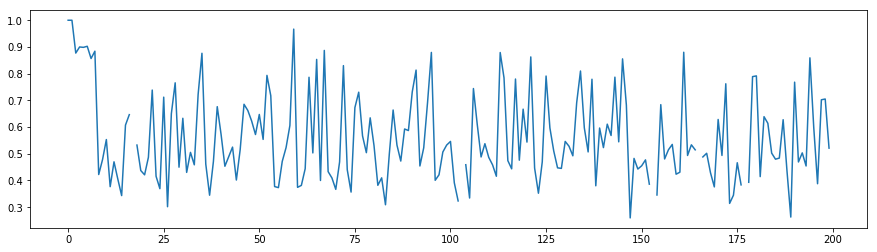

In [36]:
import numpy as np
random_point = np.random.randint(len(fc_raw)-200)
random_point = 100
print(random_point)

similarity_array = []

for fc in fc_raw[random_point:random_point+200]:
    fc = fc.strip("\n")
    fc = fc.replace("</script>", "").replace('<script type="application/ld+json">', "")
    fc = json.loads(fc)
    claim = fc["claimReviewed"]
    print(claim)
#     date_published = fc["datePublished"]
    review_url = fc["url"]
    
    similarity = calculate_claim_text(claim, text)
    print(similarity)
    similarity_array.append(similarity)
    

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(similarity_array)
plt.show()